In [1]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno

from dmba import regressionSummary

import matplotlib.pylab as plt

no display found. Using non-interactive Agg backend


In [2]:
data_df = pd.read_csv('candy_production.csv')

In [3]:
# Check the first 10 rows

data_df.head(10)

date    target
0   1/1/1972   85.6945
1   2/1/1972   71.8200
2   3/1/1972   66.0229
3   4/1/1972   64.5645
4   5/1/1972   65.0100
5   6/1/1972   67.6467
6   7/1/1972   69.0429
7   8/1/1972   70.8370
8   9/1/1972   75.0462
9  10/1/1972  106.9289

In [4]:
# Check the last 10 rows

data_df.tail(10)

date    target
538  11/1/2016  116.8431
539  12/1/2016  116.4535
540   1/1/2017  109.4666
541   2/1/2017  113.4661
542   3/1/2017  105.2245
543   4/1/2017  107.4288
544   5/1/2017  101.9209
545   6/1/2017  104.2022
546   7/1/2017  102.5861
547   8/1/2017  114.0613

In [5]:
# Show the variable names, non-null counts, and datatypes

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    548 non-null    object 
 1   target  548 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.7+ KB


In [6]:
# Convert the date string into a datetime object in Python

data_df['date'] = pd.to_datetime(data_df['date'])

In [7]:
# Show the first five rows of the date column

data_df['date'].head()

0   1972-01-01
1   1972-02-01
2   1972-03-01
3   1972-04-01
4   1972-05-01
Name: date, dtype: datetime64[ns]

In [8]:
# Check the datatypes again

data_df.dtypes

date      datetime64[ns]
target           float64
dtype: object

In [9]:
# Extract year and month from the date variable

data_df['year'] = data_df['date'].dt.year
data_df['month'] = data_df['date'].dt.month
data_df['day'] = data_df['date'].dt.day
data_df['weekday'] = data_df['date'].dt.weekday

In [10]:
# Create a new plotting object and load the time series data into it
%matplotlib inline

data_ts = pd.Series(data_df.target.values, index=data_df.date)

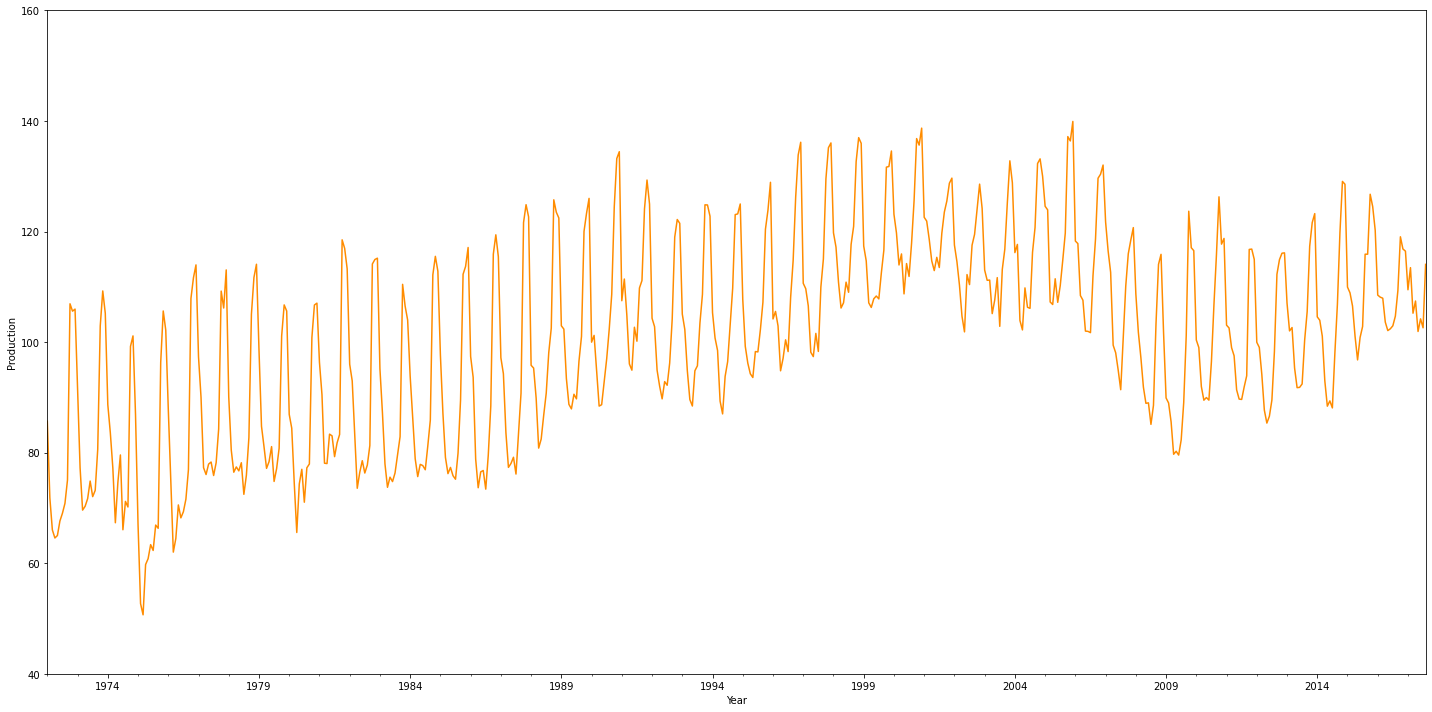

In [59]:
# Display a line chart of the time series data

data_ts.plot(ylim=[40, 160], 
               legend=False, 
               figsize=[20, 10], 
               color='darkorange')

plt.xlabel('Year')  # set x-axis label
plt.ylabel('Production')  # set y-axis label

plt.tight_layout()
plt.show()

#### Create two new variables that are required by Prophet

In [12]:
# Create two new variables, 'ds' and 'y' to match with Prophet's requirements
# Prophet will extract these two from the dataframe without any further feature selection

data_df['ds'] = data_df['date']
data_df['y'] = data_df['target']

#### Use the 'year' variable to create training and test datasets

In [13]:
# Create training and test data (training = all years less than 2010)

train_data = data_df[data_df['year']<2010]
test_data = data_df[data_df['year']>=2010]

print(train_data.shape)
print(test_data.shape)

(456, 8)
(92, 8)


In [14]:
# Load the Prophet algorithm and plotting elements

from fbprophet import Prophet
from fbprophet.plot import plot_plotly

import plotly.offline as py
py.init_notebook_mode()

### Our first time series model

In [50]:
# Create a fitted time series model

prophet_model_1 = Prophet()

prophet_model_1.add_country_holidays(country_name='US')

prophet_model_1.fit(train_data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\dgugg\Anaconda3\envs\PythonAnalytics\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [55]:
prophet_model_1.train_holiday_names

0                  New Year's Day
1       New Year's Day (Observed)
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10    Independence Day (Observed)
11       Christmas Day (Observed)
12        Veterans Day (Observed)
13     Martin Luther King Jr. Day
dtype: object

#### Generate one year's worth of predictions

In [51]:
# Make places in the dataframe to hold five years of future data

future = prophet_model_1.make_future_dataframe(periods=60, freq='m')

future.tail(15)

ds
501 2013-09-30
502 2013-10-31
503 2013-11-30
504 2013-12-31
505 2014-01-31
506 2014-02-28
507 2014-03-31
508 2014-04-30
509 2014-05-31
510 2014-06-30
511 2014-07-31
512 2014-08-31
513 2014-09-30
514 2014-10-31
515 2014-11-30

In [52]:
# Create a set of predictions for the 60 month period

forecast_1 = prophet_model_1.predict(future)

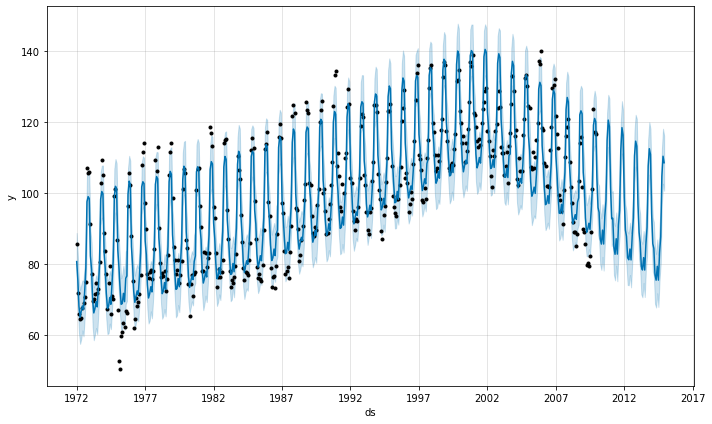

In [53]:
# Plot the actual and predicted series

fig1 = prophet_model_1.plot(forecast_1)

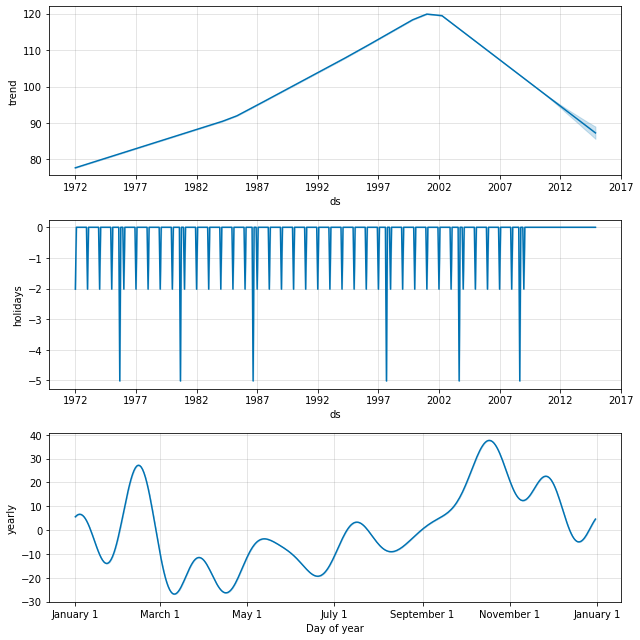

In [54]:
# Plot the components (year and monthly)

fig1 = prophet_model_1.plot_components(forecast_1)

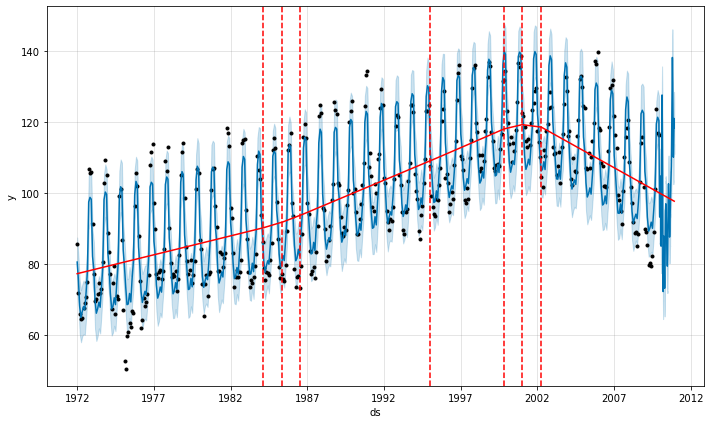

In [20]:
# Display the changepoints identified by Prophet

from fbprophet.plot import add_changepoints_to_plot

fig = prophet_model_1.plot(forecast_1)

a = add_changepoints_to_plot(fig.gca(), prophet_model_1, forecast_1)

In [21]:
# List the dates of the initial changepoints from which L1 regularization will be used to minimize them

prophet_model_1.changepoints

15    1973-04-01
29    1974-06-01
44    1975-09-01
58    1976-11-01
73    1978-02-01
87    1979-04-01
102   1980-07-01
116   1981-09-01
131   1982-12-01
145   1984-02-01
160   1985-05-01
174   1986-07-01
189   1987-10-01
203   1988-12-01
218   1990-03-01
232   1991-05-01
247   1992-08-01
261   1993-10-01
276   1995-01-01
290   1996-03-01
305   1997-06-01
319   1998-08-01
334   1999-11-01
348   2001-01-01
363   2002-04-01
Name: ds, dtype: datetime64[ns]

In [47]:
# Create a fit a new model with limited changepoints

prophet_model_2 = Prophet(n_changepoints=20)

prophet_model_2.add_country_holidays(country_name='US')

forecast_2 = prophet_model_2.fit(train_data).predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\dgugg\Anaconda3\envs\PythonAnalytics\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



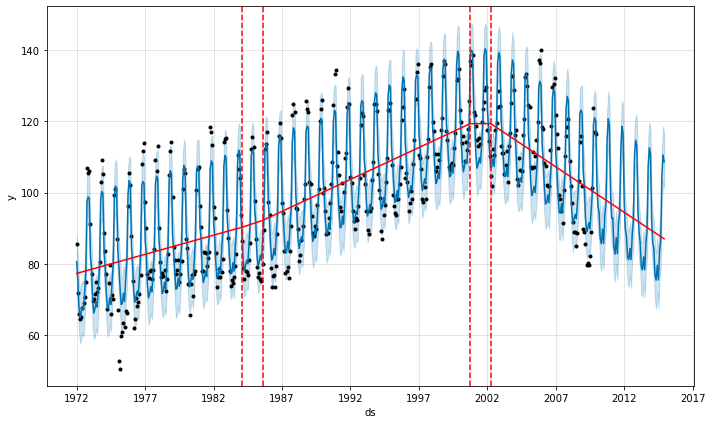

In [48]:
# Display the changepoints identified by Prophet

fig = prophet_model_2.plot(forecast_2);

a = add_changepoints_to_plot(fig.gca(), prophet_model_2, forecast_2)

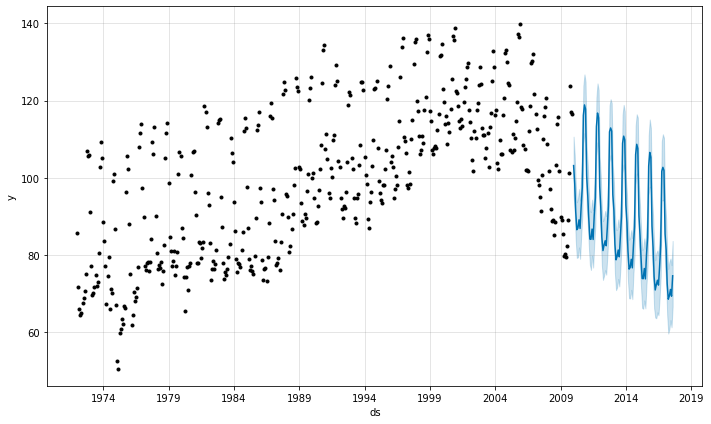

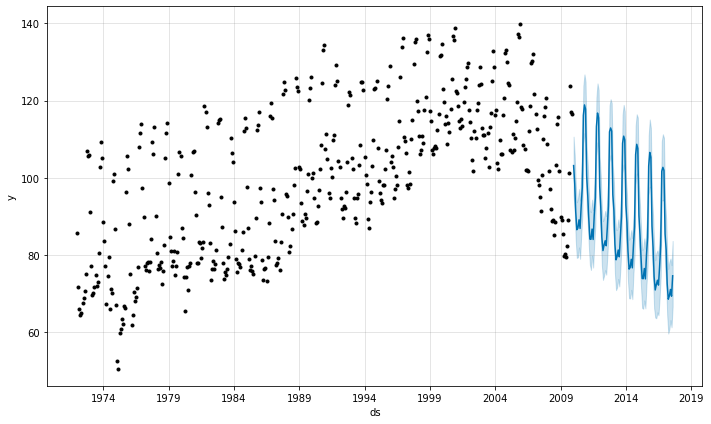

In [24]:
# forecast the data for test data

prediction_2 = prophet_model_2.predict(test_data)

prophet_model_2.plot(prediction_2)

In [25]:
# What's inside the prediction_2 model? Let's check it out.

prediction_2.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2010-01-01  99.554694   95.527415  110.666720    99.554694    99.554694   
1 2010-02-01  99.338404   91.395475  105.884350    99.338404    99.338404   
2 2010-03-01  99.143045   83.963622   98.576253    99.143045    99.143045   
3 2010-04-01  98.926755   79.298564   93.715692    98.926755    98.926755   
4 2010-05-01  98.717442   79.428492   94.483019    98.717193    98.717565   

   additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
0        3.629796              3.629796              3.629796   3.629796   
1       -0.798419             -0.798419             -0.798419  -0.798419   
2       -7.852924             -7.852924             -7.852924  -7.852924   
3      -12.330813            -12.330813            -12.330813 -12.330813   
4      -11.719407            -11.719407            -11.719407 -11.719407   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      3.629796      3.629796                   0.0   
1     -0.798419     -0.798419                   0.0   
2     -7.852924     -7.852924                   0.0   
3    -12.330813    -12.330813                   0.0   
4    -11.719407    -11.719407                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0  103.184490  
1                         0.0                         0.0   98.539985  
2                         0.0                         0.0   91.290121  
3                         0.0                         0.0   86.595942  
4                         0.0                         0.0   86.998035

### Turn predictions and actual test values into numpy vectors by extracting values only

In [26]:
yhat_2 = prediction_2['yhat'].values # convert to numpy from pandas by extracting values alone

target = test_data['y'].values 

### Compute the Mean Directional Accuracy for prophet model 2

In [27]:
import numpy as np

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

mda(target, yhat_2)

0.7582417582417582

### Compute the regression summary for prophet model_2

In [28]:
regressionSummary(target, yhat_2)


Regression statistics

                      Mean Error (ME) : 15.1826
       Root Mean Squared Error (RMSE) : 18.6777
            Mean Absolute Error (MAE) : 15.3017
          Mean Percentage Error (MPE) : 14.3250
Mean Absolute Percentage Error (MAPE) : 14.4398


In [29]:
forecast_error_2 = (target - yhat_2)

forecast_error_2

array([-2.8047896 ,  0.47551537,  0.67527916,  2.89545832,  2.97326504,
        0.36179138,  9.53962059, 14.04449673, 18.30190906, 10.05644371,
       -1.16992118,  0.94802586,  2.60526432,  7.22222922,  9.43393708,
       13.34572042,  7.2523553 ,  2.93280579,  5.55758715,  1.49550205,
       -0.93133933,  3.4812025 ,  0.04323852, -0.57527297,  2.24416808,
        6.90614514,  9.54215459,  6.49721691,  2.78051457,  2.86387533,
        7.07187003, 11.09950434, 19.48702735,  2.98978358,  3.15210313,
        4.02672039, 11.36651055, 10.46282765, 19.7854771 , 16.51508706,
       12.06931892, 10.47844946, 12.84112753, 15.49638897, 15.44513737,
        8.37486314, 10.8095315 , 13.37250715, 11.57555627, 15.60446124,
       19.97422503, 16.60200419, 11.60281091, 10.41673724, 11.36426646,
       15.5490426 , 19.50875493, 13.73918958, 20.36602469, 20.94247173,
       19.68781019, 23.76827509, 27.17018295, 27.07496628, 22.86320117,
       24.27035166, 28.95333302, 35.70214792, 31.25240654, 23.65

### Making a Tunable Time Series Model (model_3)

In [30]:
# Create a fit a new model with limited changepoints

prophet_model_3 = Prophet(changepoint_prior_scale=0.05)



prophet_model_3.add_country_holidays(country_name='US')

forecast_3 = prophet_model_3.fit(train_data).predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\dgugg\Anaconda3\envs\PythonAnalytics\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



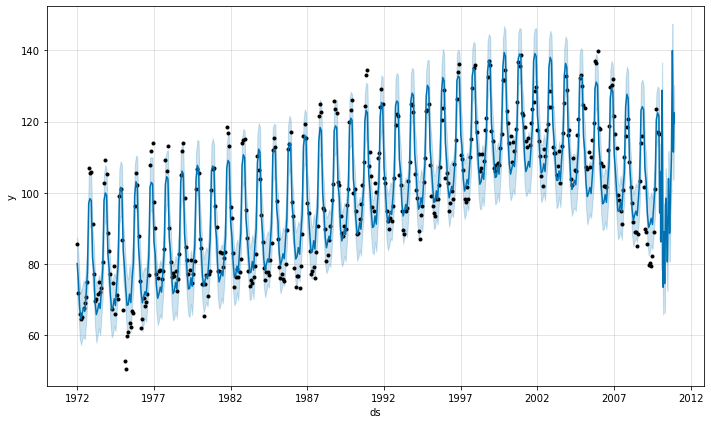

In [31]:
fig3 = prophet_model_3.plot(forecast_3)

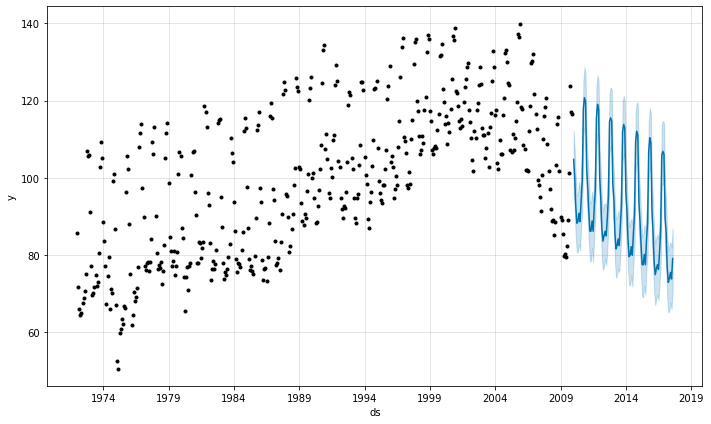

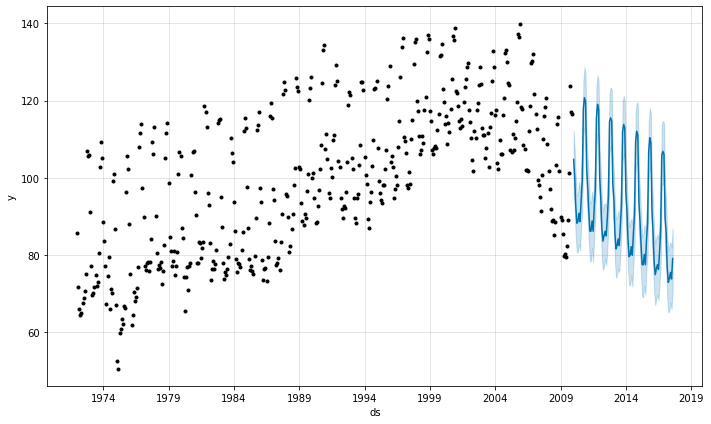

In [32]:
prediction_3 = prophet_model_3.predict(test_data)

prophet_model_3.plot(prediction_3)

In [33]:
yhat_3 = prediction_3['yhat'].values # convert to numpy from pandas by extracting values alone

target = test_data['y'].values 

### Compute the Mean Directional Accuracy

In [34]:
import numpy as np

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

mda(target, yhat_3)

0.7582417582417582

### Display the regression performance summary

In [35]:
regressionSummary(target, yhat_3)


Regression statistics

                      Mean Error (ME) : 12.1652
       Root Mean Squared Error (RMSE) : 15.8531
            Mean Absolute Error (MAE) : 12.6184
          Mean Percentage Error (MPE) : 11.4425
Mean Absolute Percentage Error (MAPE) : 11.8783
